In [17]:
import pandas as pd

#printing settings, prints all rows and columns

'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
'''

"\npd.set_option('display.max_rows', None)\npd.set_option('display.max_columns', None)\npd.set_option('display.width', None)\npd.set_option('display.max_colwidth', None)\n"

Read shapefiles

In [18]:
import geopandas as gpd

# River channel centerline
centerline = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\oulankajoki.shp')

#print(centerline)

# Feasible region
feasible_region = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\sallittualue_maalajit2.shp')

#print(feasible_region)

Plotting river channel, feasible region and coordinates.

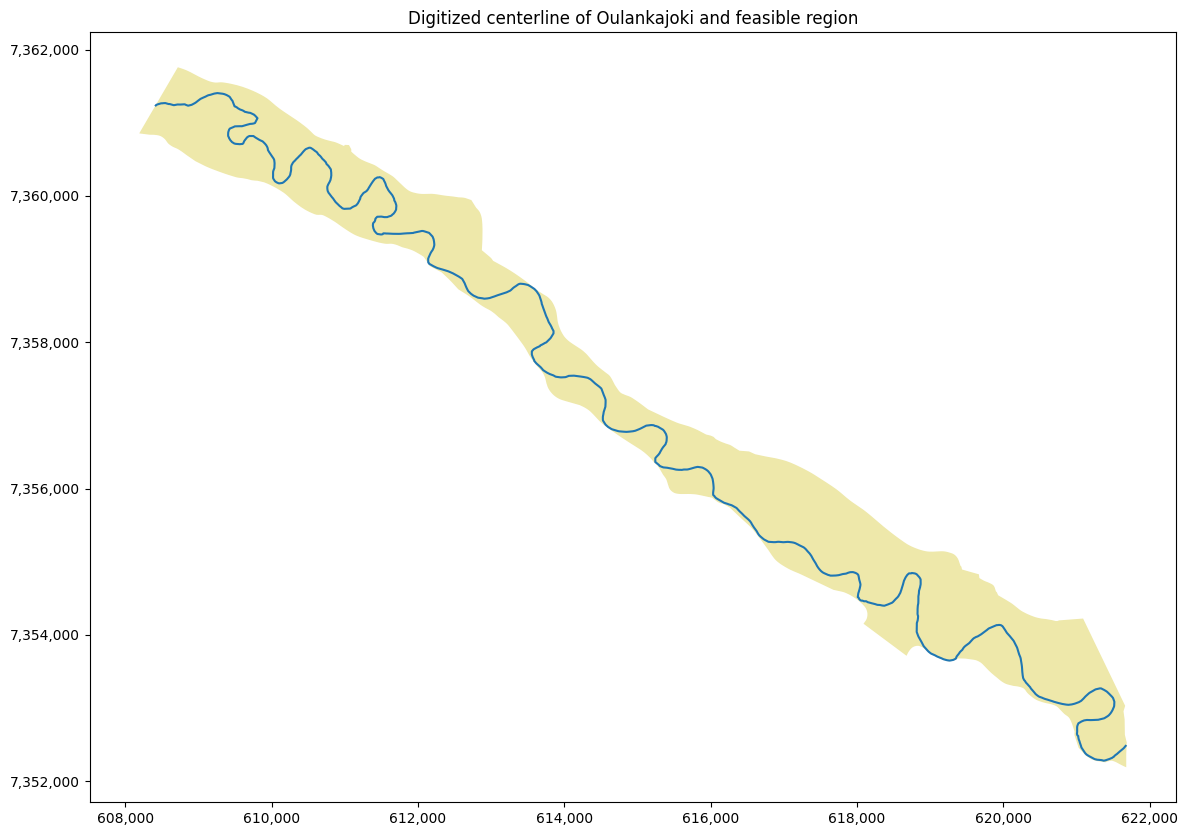

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot

fig, ax = plt.subplots(figsize=(15, 10))

# x and y axis
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

feasible_region.plot(ax=ax, color = 'palegoldenrod')

centerline.plot(ax=ax)

title_txt = "Digitized centerline of Oulankajoki and feasible region"
plt.title(title_txt)

plt.show()

Break centerline into points, and smooth with Savitzky-Golay filter

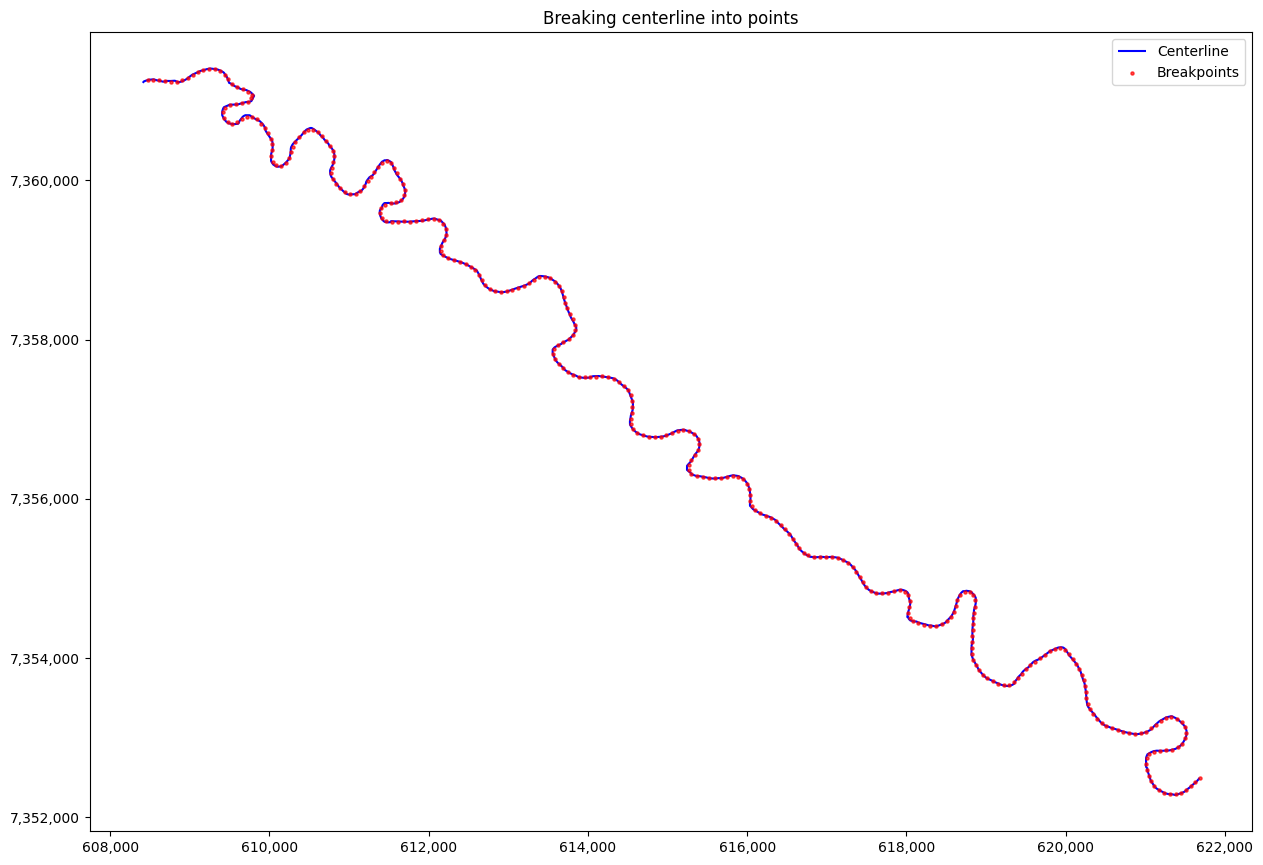

In [20]:
from shapely.geometry import LineString, Point
from scipy.signal import savgol_filter

# GeoDataFrame
points = gpd.GeoDataFrame(columns=['geometry'])

# Function to create breakpoints at given interval
def create_breakpoints(geometry, interval):

    breakpoints = LineString(geometry).interpolate(range(0, int(geometry.length), interval))

    #Smooth points using Savitzky-Golay filtering
    x_coords = [point.x for point in breakpoints]
    y_coords = [point.y for point in breakpoints]
    smoothed_x = savgol_filter(x_coords, window_length = 7, polyorder=3) 
    smoothed_y = savgol_filter(y_coords, window_length = 7, polyorder=3)
    
    smoothed_breakpoints = [Point(x, y) for x, y in zip(smoothed_x, smoothed_y)]

    # Add points to gdf
    point = gpd.GeoDataFrame(geometry=smoothed_breakpoints, crs='EPSG:3067')
    return point[::-1] 


# Divide points
points = create_breakpoints(centerline['geometry'].iloc[0], 75)


# Plot 
fig, ax = plt.subplots(figsize=(15, 15))
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

centerline.plot(ax=ax, color = 'blue', zorder = 1, linewidth = 1.5, label = 'Centerline')

points.plot(ax=ax, color='red', marker='o', markersize=5, alpha = 0.7, label = 'Breakpoints') 

title_txt = "Breaking centerline into points"
plt.title(title_txt)

ax.legend()

plt.show()


Spline curve to connect points back into a continuous line

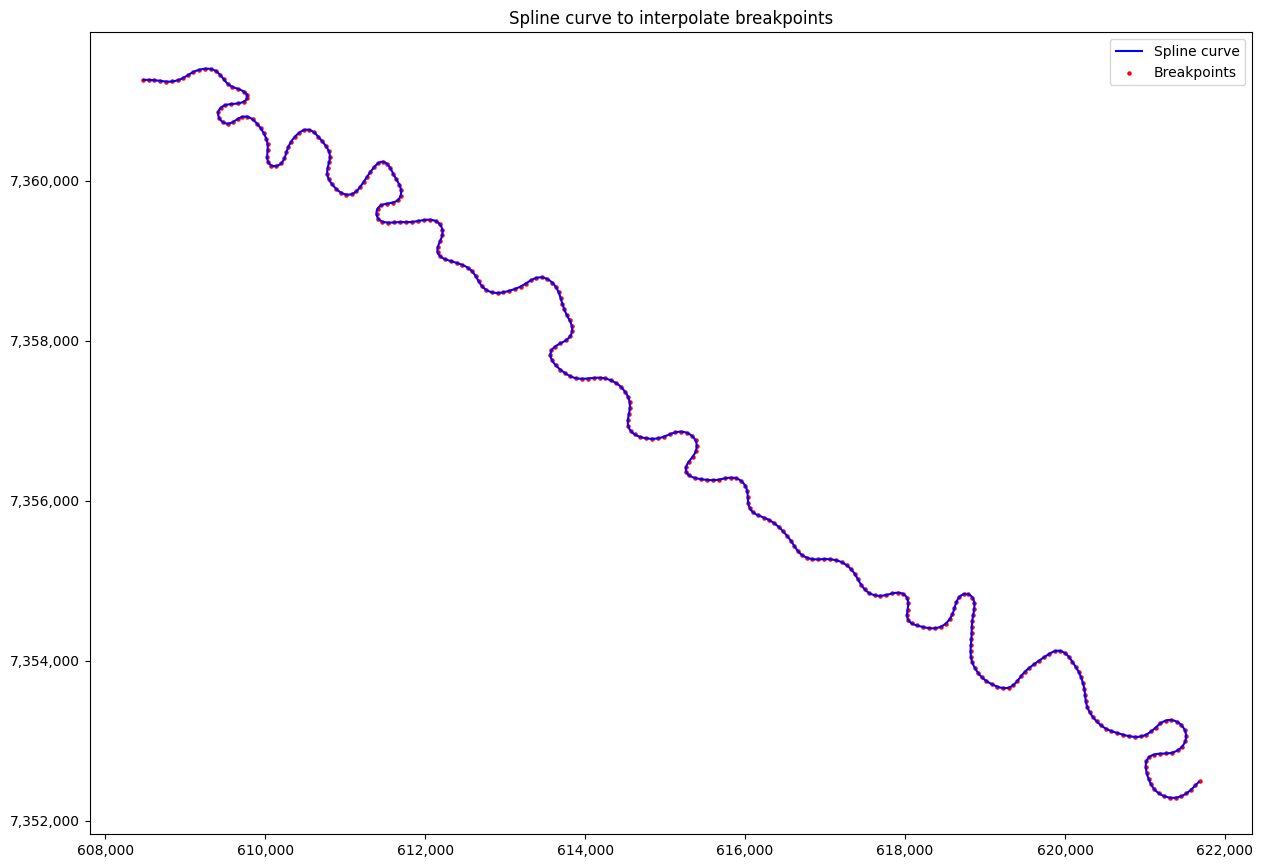

In [21]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_spline(points):
    x, y = zip(*points)

    # Spline parameters
    tck, u = splprep([x, y], s=3)  
    t_new = np.linspace(0, 1, 1000)
    spline_points = splev(t_new, tck)
    
    # Convert to Points
    spline_points = [Point(coord) for coord in zip(spline_points[0], spline_points[1])]
    bspline = LineString(spline_points)
    bspline_gdf = gpd.GeoDataFrame(geometry=[bspline])

    return bspline, bspline_gdf

# Generate spline curve
spline_ls, spline_gdf = create_spline(points['geometry'].apply(lambda point: (point.x, point.y)).tolist())

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

spline_gdf.plot(ax=ax, color='blue', label = 'Spline curve')

points.plot(ax=ax, color='red', marker='o', markersize=5, label = 'Breakpoints')

title_txt = "Spline curve to interpolate breakpoints"
plt.title(title_txt)

ax.legend()
plt.show()

Finding inflectionpoints that separate meander bends by f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T

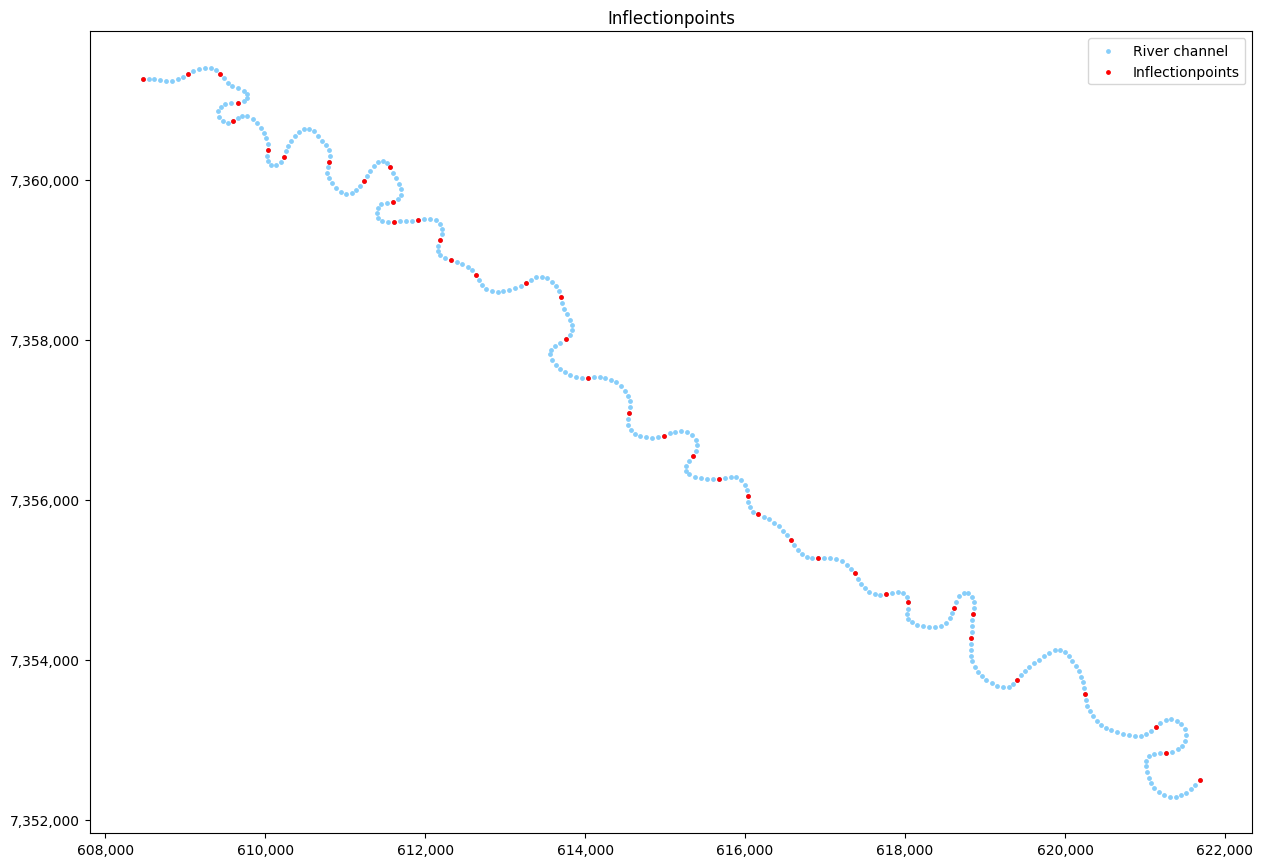

In [22]:
#Inflectionpoints defined by f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T 

import numpy as np
from numpy import linalg

def define_inflectionpoints(points, p_between):
    inflectionpoint_list = []
    points_in_between=0
    inflectionpoint_list.append(points.iloc[0]) # first

    for i in range(1, len(points)-2):
        #vectors
        v1 = (np.array(points.iloc[i-1].coords[0])) - (np.array(points.iloc[i].coords[0]))

        v2 = (np.array(points.iloc[i].coords[0])) - (np.array(points.iloc[i+1].coords[0]))
        v2_orto = np.array([-v2[1], v2[0]])
        
        v3 = (np.array(points.iloc[i+1].coords[0])) - (np.array(points.iloc[i+2].coords[0]))
        v3_orto = np.array([-v3[1], v3[0]])
        # dot product
        dot_product1 = np.dot(v1, v2_orto)
        dot_product2 = np.dot(v2, v3_orto)

        #counter
        points_in_between = points_in_between + 1

        # Check when sign changes
        if np.sign(dot_product1) != np.sign(dot_product2)  and points_in_between > p_between:
            inflectionpoint_list.append(points.iloc[i]) # add to inflectionpoint list
            
            points_in_between = 0
    inflectionpoint_list.append(points.iloc[len(points)-1]) # last
    
    return inflectionpoint_list

inflection_points = define_inflectionpoints(points['geometry'], 3)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=11)

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=6, label='River channel')

gpd.GeoDataFrame(geometry=inflection_points).plot(ax=ax, color='red', marker='o', markersize=6, label='Inflectionpoints')

title_txt = "Inflectionpoints"
plt.title(title_txt)

ax.legend()
plt.show()


Define meander bend ID's 'meander'

In [23]:
# Define bends

def define_meander(points, inflectionpoints):
    points['meander'] = None
    meander_id = 0
    j = 1

    for i in range(len(points['geometry'])):
        if points['geometry'].iloc[i].coords[0] == inflectionpoints[j].coords[0]:
            points.at[len(points) - i - 1, 'meander'] = meander_id
            meander_id += 1
            if j != len(inflectionpoints) - 1:
                j += 1
        else:
            points.at[len(points) - i - 1, 'meander'] = meander_id

define_meander(points, inflection_points)

print(points)

                           geometry meander
337  POINT (608469.424 7361261.115)       0
336  POINT (608542.494 7361261.159)       0
335  POINT (608615.932 7361256.265)       0
334  POINT (608689.479 7361249.369)       0
333  POINT (608763.416 7361240.210)       0
..                              ...     ...
4    POINT (621451.608 7352306.115)      37
3    POINT (621516.763 7352340.572)      37
2    POINT (621576.058 7352388.657)      37
1    POINT (621630.801 7352441.681)      37
0    POINT (621681.354 7352493.189)      37

[338 rows x 2 columns]


Top points.

Max distance from midpoint of line defined between inflection points

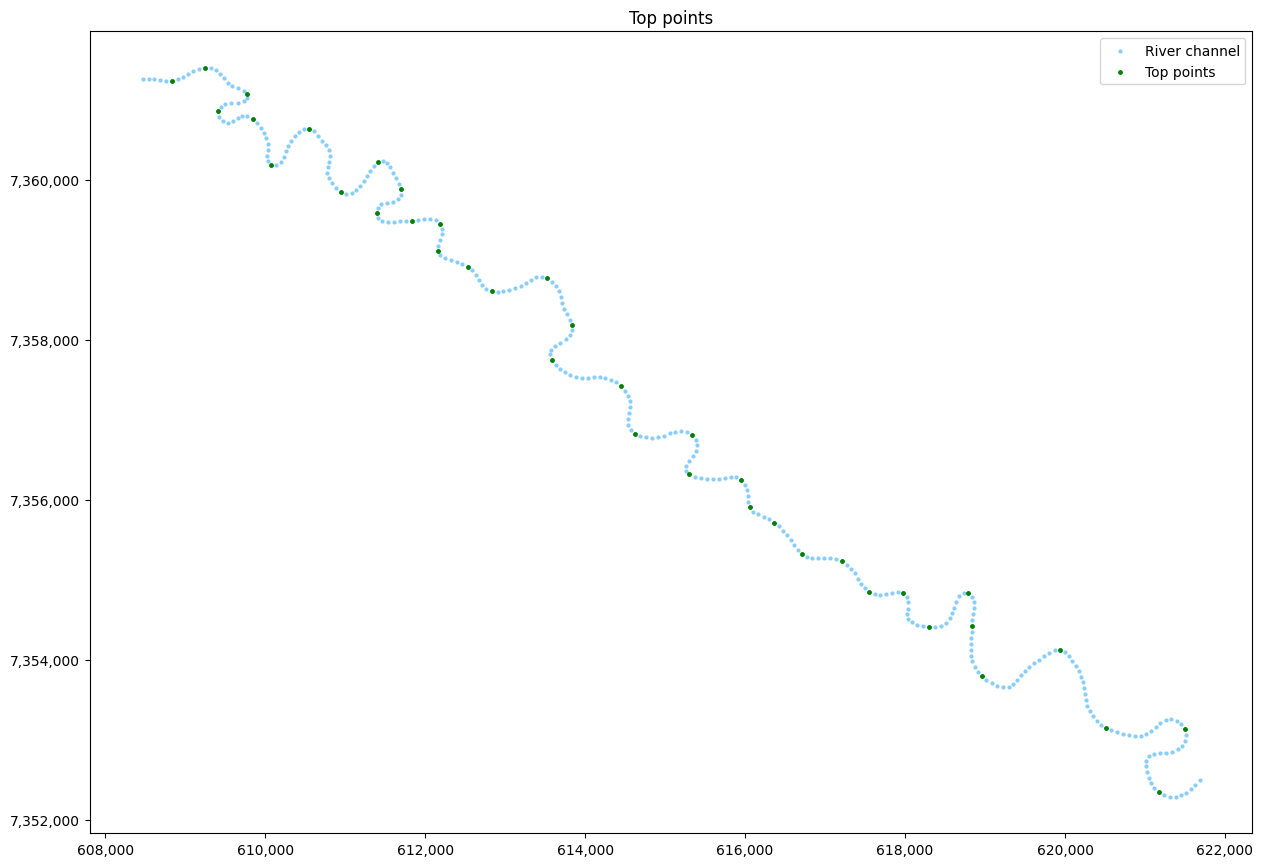

In [24]:
import numpy as np
from shapely.geometry import Point, LineString

def define_top_points(inflection_points, points):
    farthest_points = [] 
    max_distance = 0
    
    for i in range(len(inflection_points) - 1):
        p1 = inflection_points[i]
        p2 = inflection_points[i + 1]
        
        line = LineString([p1, p2])
        
        meander_points = points[points['meander'] == i]
        
        dist = []
        
        # Calculate distances of all points from line
        for j in range(len(meander_points)):
            distance = line.distance(meander_points['geometry'].iloc[j])
            dist.append(distance)
        
        max_distance = max(dist)  # Find max distance point
        farthest_point_index = dist.index(max_distance)  
        farthest_point = meander_points['geometry'].iloc[farthest_point_index]  
        
        farthest_points.append(farthest_point) 
        
    return farthest_points

top = define_top_points(inflection_points, points)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=4, label= 'River channel')

gpd.GeoDataFrame(geometry=top).plot(ax=ax, color='green', marker='o', markersize=6, label='Top points')

title_txt = "Top points"
plt.title(title_txt)

ax.legend()
plt.show()

Calculate radius of circle that intersects three consecutive points.

In [25]:
import numpy as np

def radius_and_intersectionpoint(points):
    radius_list = []
    intersectionpoint_list = []

    for i in range(len(points) - 2):

        # Three consecutive points
        p1 = np.array(points['geometry'].iloc[i].coords[0])
        p2 = np.array(points['geometry'].iloc[i + 1].coords[0])
        p3 = np.array(points['geometry'].iloc[i + 2].coords[0])

        midpoint1 = 0.5 * (p1 + p2)
        normal1 = np.array([-(p2 - p1)[1], (p2 - p1)[0]])

        midpoint2 = 0.5 * (p2 + p3)
        normal2 = np.array([-(p3 - p2)[1], (p3 - p2)[0]])
       
        A = np.array([[normal1[0], -normal2[0]], [normal1[1], -normal2[1]]])
        B = np.array([midpoint2[0] - midpoint1[0], midpoint2[1] - midpoint1[1]])
        
        if np.linalg.det(A) == 0:
            print("Singular matrix. Skipping this point.")
            continue
        else:
        # Solve
            solution = np.linalg.solve(A, B)

            # intersection
            intersection_points = midpoint1 + solution[1] * normal1
            intersectionpoint_list.append(intersection_points)
        
            # radius
            radius = np.linalg.norm(intersection_points - p2)
            radius_list.append(radius)

    return radius_list, intersectionpoint_list, solution, A, B 

rad, inter, sol, A, B = radius_and_intersectionpoint(points)

print("Radius:", rad)



Radius: [1084.7198792379877, 2724.542584162364, 2473.1896949573293, 533.5002021769382, 384.8413208842939, 396.363895846451, 500.1644556939617, 37059.0900641687, 469.59303420038856, 404.02583168467106, 353.66437886487046, 216.28801177659665, 203.2224678994972, 488.9055720042368, 2442.9325561302435, 281.05646735031263, 283.26670539275574, 942.7723298111478, 258.2620652130816, 89.27017065157425, 48.668608067898234, 117.37359175403299, 347.4298010885354, 819.9401861306272, 248.29576048242384, 129.46874055525524, 94.38253518662685, 115.99256143919446, 144.87751419986293, 105.62582072954663, 281.49650031129573, 573.2366660706939, 157.75508661127603, 119.19497872411489, 245.2363282697441, 586.343054652395, 658.1678358880574, 543.873033265019, 429.13384978270096, 295.86269897428235, 1012.0826085864747, 318.3743679313411, 136.41205897533857, 80.34143144126399, 101.35817303661322, 135.73156508499636, 321.4457172517039, 3235.912851512359, 549.0995074892652, 413.4072284366426, 448.1836815877932, 3

Curvature (Inverse of radius) 

Calculates curvature for each point. 

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


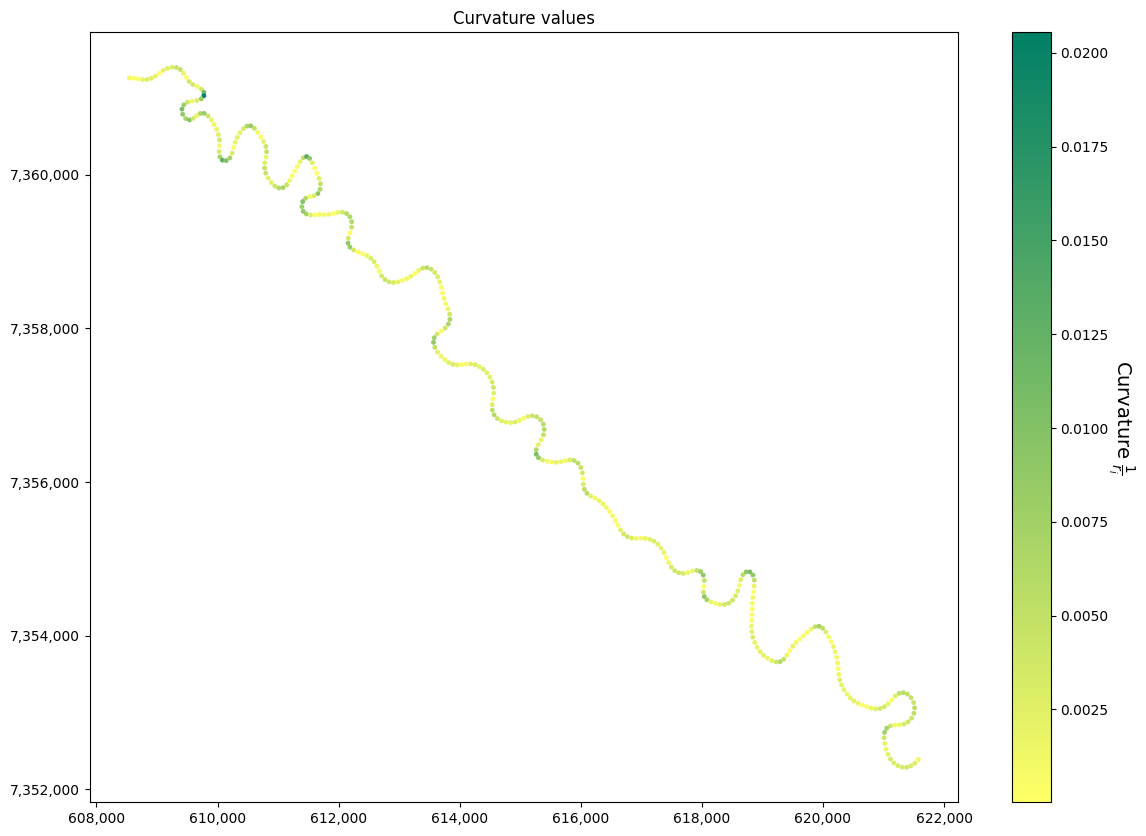

In [26]:
#Curvature 1/R

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def calculate_curvature(points, radius):
    curvature_list = []
    shifted_radius = [np.nan] + radius[:-1]

    points['curvature'] = np.nan

    for i in range(len(points) - 2):
        radius = shifted_radius[i]
        curvature = 1 / radius
        curvature_list.append(curvature)

    points['curvature'][:-2] = curvature_list 

calculate_curvature(points, rad)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['curvature'],
    cmap= 'summer_r',
    s=6
)

cbar = plt.colorbar(scatter, label='Curvature')
cbar.set_label(r'Curvature $\frac{1}{r_i}$', rotation=270, labelpad=20, fontsize = 14)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=12)

title_txt = "Curvature values"
plt.title(title_txt)

plt.show()


Normalized curvature.

curvature_ij / max curvature of meander_j

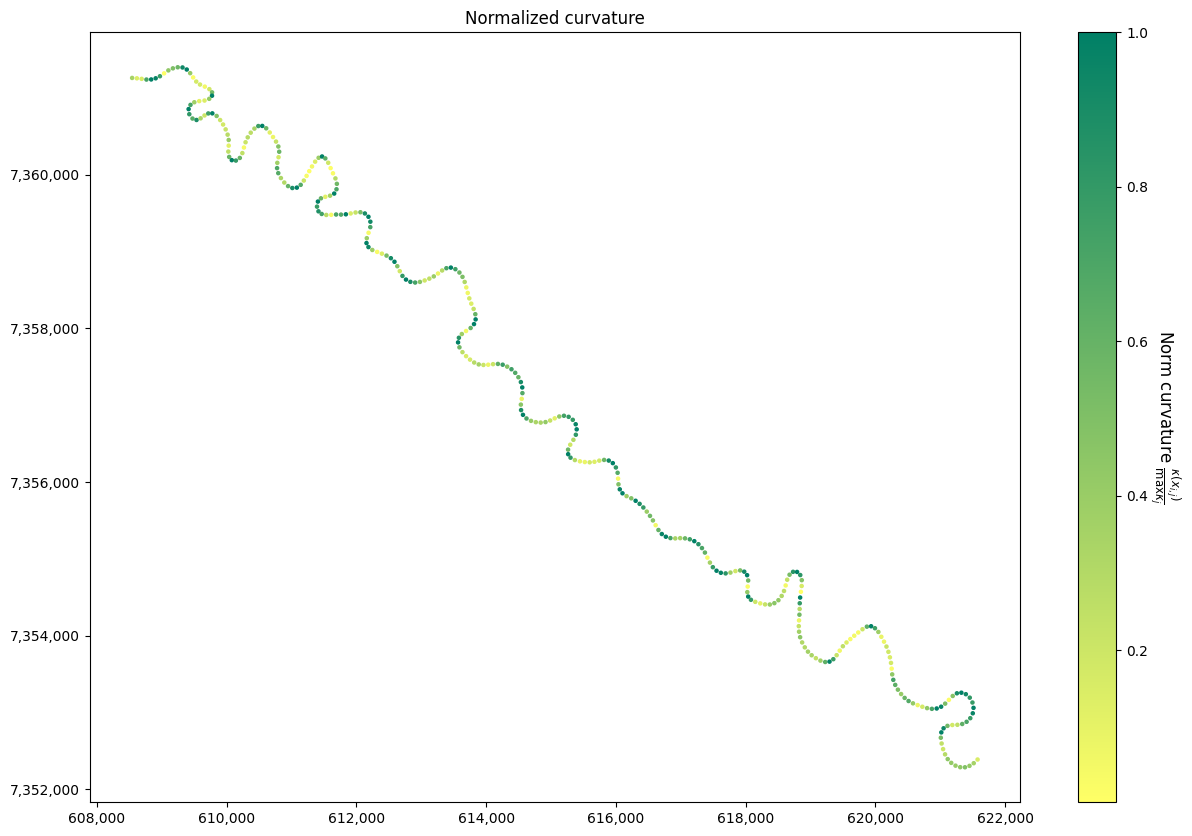

In [27]:
# Norm curvature k(x_i,j)/K_M_j


def define_normalized_curvature(points):
    points['norm_curvature'] = None

    for i in range(max(points['meander'])+1): 

            pm = (points['meander'] == i)
            filtered_pm = points[pm]

            maxcurvature = filtered_pm['curvature'].max()

            for index in filtered_pm.index:
                points.loc[index, 'norm_curvature'] = filtered_pm.loc[index, 'curvature'] / maxcurvature

define_normalized_curvature(points)

#Plot

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['norm_curvature'],
    cmap='summer_r',
    s=5
)

cbar = plt.colorbar(scatter, label='Norm curvature')
cbar.set_label(r'Norm curvature $\frac{\kappa(x_{i,j})}{\max \kappa_j}$', rotation=270, labelpad=25, fontsize = 12)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

#ax.tick_params(axis='both', which='major', labelsize=11)

title_txt = "Normalized curvature"
plt.title(title_txt)

plt.show()
                  

Function that verifies whether point lies within the feasible area.

In [28]:
def check_feasible_region(edellinen, point, feasibleregion):

    if Point(point).within(feasibleregion.geometry.iloc[0]):
        new_p = Point(point)
    else:
        new_p = edellinen

    return new_p

Formation of new oxbow-lakes

In [29]:
import geopandas as gpd
import pandas as pd

def new_oxbow(points, inflection, meters):
    new_points = points.copy()
    oxbows = []

    for i in range(len(inflection) - 1):
        if inflection[i].distance(inflection[i + 1]) < meters:
            oxbow_points = new_points[new_points['meander'] == i]
            if not oxbow_points.empty:
                oxbows.append(gpd.GeoDataFrame(oxbow_points, geometry='geometry'))

            new_points = new_points[new_points['meander'] != i]

    if oxbows:
        oxbow_gdf = pd.concat(oxbows, ignore_index=True)
    else:
        oxbow_gdf = gpd.GeoDataFrame()

    return new_points, oxbow_gdf

Define directions D and L.

In [30]:
import math

def define_directions_top(inflectionpoints, toppoints):
    D_list = []
    L_top_list = []
    j = 0
    
    for i in range(len(inflectionpoints) - 1):

        # D points
        x1_inf, y1_inf = inflectionpoints[i].x, inflectionpoints[i].y
        x2_inf, y2_inf = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Direction of D
        v_inf = (x2_inf - x1_inf, y2_inf - y1_inf)

        # Length of D
        v_inf_length = math.sqrt(v_inf[0] ** 2 + v_inf[1] ** 2) 

        # Norm D
        D = (v_inf[0] / v_inf_length, v_inf[1] / v_inf_length)
    
        # L points
        x_mid , y_mid  = 0.5*(x1_inf + x2_inf) , 0.5*(y1_inf + y2_inf)
        x_top, y_top = toppoints[j].x, toppoints[j].y
        j = j+1

        # Direction L
        v_top = (x_top - x_mid, y_top - y_mid)

        # Length L
        v_top_length = math.sqrt(v_top[0] ** 2 + v_top[1] ** 2)

        # Norm L
        L = (v_top[0] / v_top_length, v_top[1] / v_top_length)

        D_list.append(D)
        L_top_list.append(L)

    return D_list, L_top_list

D, L_top = define_directions_top(inflection_points, top)
print("D:",  D)
print("L:", L_top)


D: [(0.9944683330267104, 0.10503682500473686), (0.9999812269670741, 0.006127455705669588), (0.5275604178064293, -0.8495175133944596), (-0.2523624749353141, -0.9676327718946496), (0.7730764065544905, -0.6343129114473363), (0.9080230009268574, -0.418920314365136), (0.9953525611076735, -0.09629786652047546), (0.8721400044263345, -0.4892563874690173), (0.8903223945521963, 0.4553306861598977), (0.0664222514498862, -0.9977916037491638), (0.0693120540966272, -0.9975950276324087), (0.9982406754751285, 0.05929210594134007), (0.7386009235264279, -0.6741429193916583), (0.46994456001272666, -0.8826959332150822), (0.857611809388715, -0.5142975640589935), (0.9887978286914664, -0.14926102630975632), (0.9234571600099264, -0.3837015423820983), (0.12565109266773133, -0.9920744946380817), (0.4933154534333046, -0.8698504833613034), (0.7579293900587316, -0.6523365999889927), (0.8409778275382019, -0.5410695829457853), (0.8191550844474061, -0.5735720945303763), (0.7499883218504748, -0.6614510693074044), (0.8

Migration offsets OD and OL.

Accepting/Not accepting negative offsets of lateral and downstream migration

Model created by Parquer, M. N., Collon, P., & Caumon, G. (2017). Reconstruction of Channelized Systems Through a Conditioned Reverse Migration Method.

In [31]:
def offsets(points, OD, OL, sD, sL, w):
    od_xi = []
    ol_xi = []

    max_curvature=points['curvature'].max()

    for i in range(len(points)):
            
        if w > 0:
            OD_xi = OD - (sD * (points['curvature'].iloc[i] / max_curvature))

            OL_xi = OL - (sL * (1 - (points['curvature'].iloc[i] / max_curvature)))


        elif w < 0:
            OD_xi = OD - (sD * (1 - (points['curvature'].iloc[i] / max_curvature)))

            OL_xi = OL - (sL * (points['curvature'].iloc[i] / max_curvature))

        '''
        
        Accepting negative offsets of lateral and downstream migration

        '''

        #od_xi.append(OD_xi)
        #ol_xi.append(OL_xi)

        '''
        
        Not accepting negative offsets of lateral and downstream migration

        '''
        
        od_xi.append(np.abs(OD_xi))
        ol_xi.append(np.abs(OL_xi))

    return od_xi, ol_xi


Algorithm to simulate river channel migration to the future.

36
D [(0.9944683330267104, 0.10503682500473686), (0.9999812269670741, 0.006127455705669588), (0.5275604178064293, -0.8495175133944596), (-0.2523624749353141, -0.9676327718946496), (0.7730764065544905, -0.6343129114473363), (0.9080230009268574, -0.418920314365136), (0.9953525611076735, -0.09629786652047546), (0.8721400044263345, -0.4892563874690173), (0.8903223945521963, 0.4553306861598977), (0.0664222514498862, -0.9977916037491638), (0.0693120540966272, -0.9975950276324087), (0.9266521289183409, -0.3759199808085578), (0.46994456001272666, -0.8826959332150822), (0.857611809388715, -0.5142975640589935), (0.9887978286914664, -0.14926102630975632), (0.9234571600099264, -0.3837015423820983), (0.12565109266773133, -0.9920744946380817), (0.4933154534333046, -0.8698504833613034), (0.7579293900587316, -0.6523365999889927), (0.8409778275382019, -0.5410695829457853), (0.8191550844474061, -0.5735720945303763), (0.7499883218504748, -0.6614510693074044), (0.8570383966249481, -0.5152525465347437), (0

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


36


C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9958200199174477, 0.09133722095407763), (0.9997436920238839, -0.022639572841675278), (0.46510135252067253, -0.8852574381971839), (-0.26951935765013246, -0.9629949718725742), (0.8255107105889, -0.56438645155869), (0.9673493706520968, -0.2534466316584071), (0.9785127144586169, -0.20618648753696048), (0.7680951824508825, -0.6403356859458527), (0.8766925183653502, -0.4810511700871541), (0.21026816998589598, -0.9776437473286383), (0.9643395024509246, -0.26466832831433273), (0.29387857464686296, -0.9558427607946446), (0.8775389411669099, -0.4795053771707455), (0.9824622705784167, -0.18646148902629125), (0.9222304056903347, -0.3866407619745243), (0.05525155927153302, -0.9984724659188475), (0.5408483360048223, -0.8411201325855986), (0.7549914839823094, -0.6557345950262119), (0.8434535440173777, -0.5372021212584008), (0.8864008082485897, -0.4629185750607194), (0.6511502241998851, -0.7589488688471967), (0.8777353395849027, -0.47914577494096244), (0.5675181113139511, -0.8233609131666658), (

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9967512718894251, 0.08054130609080955), (0.9996132828732568, 0.027807997111447807), (0.43102317899161263, -0.9023408553157528), (-0.007771089871267374, -0.9999698046252261), (0.7555352526513068, -0.6551079926249763), (0.98395033093681, -0.17844255728200653), (0.943014803457485, -0.3327507783011797), (0.9709806974993882, -0.23915786644725145), (0.5373646279991886, -0.8433500202023438), (0.5806617300259858, -0.8141449227767923), (0.9486080932666955, -0.31645329100662617), (0.23822363264617222, -0.971210327812087), (0.8554910227415158, -0.5178176416545458), (0.9854641205845333, -0.16988368679938765), (0.961964240165463, -0.2731754027047154), (-0.014478896985290635, -0.9998951752769334), (0.6603701934535736, -0.750940215728316), (0.8004880259706093, -0.5993487467891103), (0.822699445110095, -0.5684765808857406), (0.7324573226151702, -0.6808129482812563), (0.6989527968273722, -0.7151678039503694), (0.9351357334016817, -0.35428965567075077), (0.4297030619779659, -0.9029702534008306), (

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37
D [(0.9981544779029105, 0.060725927266433236), (0.9904185558486799, 0.1380980964047486), (0.2741491948149325, -0.9616871731401663), (0.21001606403095147, -0.9776979353813464), (0.8019964861465934, -0.5973287505289839), (0.999756155220033, -0.02208234814636481), (0.9143758489709058, -0.4048664061375491), (0.8963021829343852, -0.44344379222969843), (0.6820852806882522, -0.7312726371664867), (0.606266401401173, -0.7952616239528171), (0.9193925018150475, -0.39334136269437525), (0.4639556416382403, -0.8858584325906982), (0.8148222517490044, -0.5797108745354721), (0.9953433206240416, -0.09639333010694495), (0.9540025608669986, -0.2997984553983036), (-0.009782009903953939, -0.9999521549965473), (0.6182394699364763, -0.7859897949799761), (0.8046009460071903, -0.5938158954459996), (0.8370067360488366, -0.5471925838394314), (0.776274147815302, -0.6303954690776469), (0.7231086442816086, -0.6907343111249175), (0.890543330829196, -0.4548984237339595), (0.576279229670959, -0.817252867507876), (0.

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37


C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9982509794089703, 0.05911837370083262), (0.9977988147209697, 0.06631383974275588), (0.3212320972795759, -0.9470004961336425), (-0.07156591808022732, -0.9974358723092598), (0.769433604387475, -0.6387268026623736), (0.9930606317137483, 0.11760349374185763), (0.9418426469818895, -0.33605420444646705), (0.8941661689971292, -0.4477352590772779), (0.6912425336438452, -0.7226228336287454), (0.5764211324416065, -0.8171527874729034), (0.9452535078876666, -0.32633695136478336), (0.19276719289422725, -0.9812445206693793), (0.9038613484434722, -0.42782550507180855), (0.9747712294154822, -0.2232062953947074), (0.9231798119957381, -0.3843683581195435), (-0.021406991836291692, -0.9997708440940458), (0.5789716141554705, -0.815347698839096), (0.8512574470508829, -0.5247482814077751), (0.7498693318818701, -0.6615859619906077), (0.9017729780963253, -0.4322100137378639), (0.5062461193344496, -0.8623890459988521), (0.9298065839259937, -0.36804852463754595), (0.5786893907391613, -0.8155480298829362), 

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


37


C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9955798842954936, 0.09391854974482725), (0.9999993858185382, 0.0011083151836210406), (0.15276039078890882, -0.9882632559222364), (-0.15447583744348067, -0.9879965666165724), (0.8816759942120125, -0.4718553181116637), (0.9980567545842408, -0.06231143256877335), (0.9278042711618342, -0.3730673322791179), (0.9135797287777361, -0.4066596601169066), (0.5907790448042035, -0.8068333906205376), (0.6961242202033707, -0.7179213536636508), (0.9357854250588713, -0.3525700472918644), (0.3867572553973732, -0.9221815577192437), (0.840083054827146, -0.5424577965079775), (0.992784541500832, -0.11991185995131143), (0.9122576158986068, -0.40961694573709967), (-0.05192762370716648, -0.9986508508463442), (0.5700911646438513, -0.8215814408779066), (0.8658892006381893, -0.5002358365992559), (0.7820520292884731, -0.6232131445065816), (0.8335424387411571, -0.5524554306163025), (0.5542838626375651, -0.8323276996589629), (0.9525019884882213, -0.3045323659744303), (0.4367247459050443, -0.8995951846881877), 

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9985048206032184, 0.05466372867024817), (0.9871102901973794, 0.16004147895606713), (0.1103793564979104, -0.9938895299071758), (0.3050204157252037, -0.9523458121873712), (0.83857633141505, -0.5447841190696333), (0.9972244677991086, 0.07445374955490462), (0.8989631755664477, -0.43802421049011453), (0.8382606774847258, -0.5452696916048503), (0.7532547039295991, -0.6577289342943125), (0.70707395777949, -0.7071396030700359), (0.9128876972452754, -0.4082107938531495), (0.5046364828256527, -0.8633319293304024), (0.8802159587932709, -0.47457335142804125), (0.9652412705980807, -0.261360459010545), (0.9156236696792475, -0.40203643556661395), (-0.14703766680475916, -0.9891308935326065), (0.6411440128646092, -0.7674205853167257), (0.8397099131571338, -0.5430352306670708), (0.8412916727731254, -0.5405814659443999), (0.7824478396954214, -0.622716129673841), (0.586999805285615, -0.8095870728925023), (0.929158641647818, -0.36968123924697827), (0.6262324136155365, -0.7796364307401621), (0.7953875

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9976077020127664, 0.06912939233645363), (0.9942824014916102, 0.10678251768935096), (0.3043695834292224, -0.9525540177245182), (0.6717871429235274, -0.7407442437188723), (0.9920915111370278, -0.12551666634295577), (0.9215295539807, -0.3883082295549916), (0.828338993961619, -0.5602271959505829), (0.7424897761277037, -0.6698573970225546), (0.7691374864168973, -0.6390833490150537), (0.9272759891397445, -0.37437847155640286), (0.37601027045693924, -0.9266154955054978), (0.8266757616383944, -0.5626785806475848), (0.9873136949806142, -0.1587818242234513), (0.9171654297355477, -0.39850668061904293), (-0.04980442093585289, -0.9987589897744322), (0.5879452397153936, -0.8089007325352154), (0.8471052370330365, -0.5314251757220418), (0.7851545452955119, -0.6192998788969669), (0.8352459322084375, -0.549876561356509), (0.5601061364544561, -0.8284208567546221), (0.9221347477918819, -0.3868688497602288), (0.5646568502359155, -0.825325778999817), (0.805090714159642, -0.5931517023274212), (0.837723

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9918356815575354, 0.12752247170322295), (0.998476125900043, -0.05518537856752755), (0.34147317029354507, -0.93989152244803), (0.6424640260826302, -0.7663158455817662), (0.9810213264680075, -0.1938998633701197), (0.8801550845506463, -0.47468624073133264), (0.9030711732441609, -0.429490926627577), (0.7628702076708297, -0.6465516578342871), (0.7447551620832292, -0.6673378069241866), (0.9043907933037194, -0.4267051593166749), (0.3792436133040597, -0.9252968614277696), (0.8576745016740304, -0.514193007710338), (0.965578330565975, -0.26011245172314357), (0.9348929497598174, -0.35492981346935), (-0.05324940792377526, -0.9985812438433678), (0.5203291734118547, -0.8539657787619689), (0.849721637127799, -0.5272315804244405), (0.827640505654462, -0.5612585798008137), (0.7786353272043549, -0.6274767144917548), (0.6231785850131084, -0.7820795683183775), (0.9169342633977777, -0.3990382896504729), (0.5346980146260999, -0.8450432137795718), (0.8369943795382919, -0.5472114843653317), (0.782523892

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9950544674426395, 0.09933079493513053), (0.9946790553990144, -0.1030222148399285), (0.3283907510449198, -0.9445419602263064), (0.583110327676692, -0.8123929749553359), (0.9989886024054542, -0.044964121964042036), (0.8771838390749208, -0.48015467556380553), (0.8930652382871218, -0.4499271942916612), (0.7935240833045305, -0.6085388477457332), (0.6876429419365829, -0.726049023417015), (0.9506786337335156, -0.3101775868153216), (0.33672031079169384, -0.9416047112776916), (0.8442524403081493, -0.535945722096683), (0.9871496496380507, -0.15979852696277874), (0.8557392923178412, -0.51740725118939), (-0.09888798925381423, -0.9950985707865013), (0.5513613942575755, -0.8342665119267), (0.8477753412486013, -0.5303555135669068), (0.8101489166829087, -0.5862241318791896), (0.871546582510904, -0.49031271094431556), (0.5184768403681209, -0.8550916711101154), (0.9337598014031219, -0.3579003119356034), (0.5569745729771319, -0.8305295449632973), (0.7867408681895444, -0.617283408427897), (0.8020924

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9987125910715606, 0.05072632881581223), (0.9996078316380578, 0.028003266378412058), (0.38070777304151604, -0.9246954047391873), (0.6517016489291287, -0.7584754187071949), (0.8557675868730468, -0.5173604519650515), (0.8426046234257801, -0.5385326810709813), (0.9462848029527814, -0.32333430331564833), (0.720996056318848, -0.6929391652754724), (0.7607738277177701, -0.6490170899596193), (0.9233800764602667, -0.3838870073292818), (0.34428710006703717, -0.9388644165839017), (0.8684821284499488, -0.49572047825669524), (0.97784671595816, -0.2093222398357171), (0.8734857390425639, -0.48684973419861893), (-0.186824605460629, -0.9823932851941122), (0.6188416777630912, -0.7855157400481307), (0.8786103359584645, -0.4775393989473059), (0.7922666205319558, -0.6101750584798382), (0.8444306267509848, -0.5356649294147778), (0.5282566118666429, -0.8490847731641259), (0.9331280824780084, -0.3595441303802848), (0.5585130042442, -0.8294957649621354), (0.818282747175154, -0.5748159232967394), (0.730790

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9935874953064363, 0.1130658620923328), (0.9994129285379625, -0.034260739501260185), (0.34362823165877276, -0.9391057652932734), (0.5319143536992087, -0.8467981579625412), (0.9995182481821135, -0.031036616293645996), (0.9039992923502633, -0.4275339512018001), (0.8676628080978642, -0.49715314687099044), (0.8199250975865134, -0.5724708152803479), (0.5940491437027337, -0.8044287506461023), (0.9751924505076495, -0.22135872350753558), (0.4124569467425873, -0.9109770947086335), (0.8975881123571634, -0.4408350945139283), (0.9174218342125284, -0.39791604404713316), (0.8632157639714982, -0.5048351660008471), (-0.2602167917530479, -0.9655502168658815), (0.7220397066724447, -0.6918516184763682), (0.8513920420800389, -0.5245298758724628), (0.6925805499974149, -0.7213405449337216), (0.849326101196759, -0.5278685194496001), (0.7271042705657396, -0.6865270422387336), (0.888923122400631, -0.4580564184262818), (0.6121535659551903, -0.7907389023491537), (0.8079340670826769, -0.5892728936980255), (0

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9982333893120714, 0.059414648551804596), (0.9999999176627579, 0.00040580103170447787), (0.3609612587779586, -0.9325808113302737), (0.6108145975250993, -0.7917736592298655), (0.9999519455523109, -0.009803396663819512), (0.8070805170388203, -0.5904413933798601), (0.9116933812298115, -0.4108712433618997), (0.7797624324457872, -0.6260755137730825), (0.6129601054086793, -0.7901138583630721), (0.9460389102845969, -0.3240530515633702), (0.4930514457508421, -0.8700001562315978), (0.8588898292479412, -0.512160386221389), (0.9696482605106017, -0.24450409176282586), (0.8554022303193992, -0.5179643080025856), (-0.17822582014437227, -0.9839896122591264), (0.6405000673763909, -0.7679581132398033), (0.8518908332251252, -0.5237193984062479), (0.7641832794230712, -0.6449991592631734), (0.831126061784978, -0.5560840488827141), (0.7011178459131115, -0.7130454166055332), (0.9043823798125973, -0.4267229910427879), (0.5764074389755209, -0.8171624466981342), (0.7821504772369492, -0.6230895850180876), (

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.991932656628062, 0.12676594461761137), (0.9733474323131133, -0.22933550970024108), (0.4109058598670585, -0.9116777798799931), (0.5483502905615066, -0.8362487422059965), (0.9999020151484249, 0.013998575003155163), (0.8644931917724783, -0.5026445278514758), (0.913048012303094, -0.4078520898921193), (0.6975976840509958, -0.7164896867413286), (0.7838494270542852, -0.6209509446861876), (0.8989817980775304, -0.437985989188342), (0.524836465981612, -0.8512030803374316), (0.9041406061046823, -0.4272350224322178), (0.9115992831735118, -0.41107997630332155), (0.5730918951241695, -0.8194911102281636), (0.7204503986179606, -0.6935064694227603), (0.8015746380325487, -0.5978947228927418), (0.7997178040581016, -0.6003760770321283), (0.9333309875751575, -0.35901708543185107), (0.45884236205256423, -0.8885176907558023), (0.9557326947404609, -0.2942363271320129), (0.5963215957359499, -0.8027456349672232), (0.7786980205343997, -0.6273989104356236), (0.7081720830300672, -0.7060398719738536), (0.9807

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.994722404651835, 0.10260281518394661), (0.9465899205123771, -0.32243995159466776), (0.39628064379035705, -0.9181294306126453), (0.5921613351730632, -0.8058194296032176), (0.9924713060566516, -0.12247737200889079), (0.8395567550214209, -0.5432719899809874), (0.9189696860330849, -0.3943281833096049), (0.8465614238549828, -0.5322910441108548), (0.6666709949207985, -0.7453521211691242), (0.9573211933847035, -0.28902617994999563), (0.3359527342288531, -0.9418788459054369), (0.898012301702593, -0.43997034671760665), (0.942349089606867, -0.3346314290635428), (0.5351171816970104, -0.8447778417149971), (0.7627078092330358, -0.6467432239575016), (0.8092038246181709, -0.5875280165433173), (0.7697352792998213, -0.6383632193361598), (0.8828353306737705, -0.4696826363770905), (0.6664372133832702, -0.7455611582009497), (0.8947906151141392, -0.44648600773558444), (0.6859772565334533, -0.7276229817143195), (0.7582782743051953, -0.6519310229746201), (0.7168709974854505, -0.6972058325661192), (0.90

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9990916943228327, 0.04261204448429649), (0.9090030623801166, -0.416789434347333), (0.47764681478028104, -0.8785519451519369), (0.6351454158173047, -0.7723925820243636), (0.9787843010390612, -0.20489336748532466), (0.8215912989760759, -0.570076957477501), (0.9111031814583649, -0.4121783506401638), (0.8910941398325296, -0.45381850332057205), (0.7326296938560567, -0.680627454398058), (0.8959787060787328, -0.4440970144613447), (0.45105819938338865, -0.8924945382292349), (0.8662664345338545, -0.4995822899182908), (0.8822418936471338, -0.4707963902728222), (0.5949195112240754, -0.8037852792661154), (0.7770592657071319, -0.6294274363091371), (0.8183077443741933, -0.5747803367350173), (0.8067459699318283, -0.5908984176647909), (0.8179709312674868, -0.5752595549848786), (0.6584279145514773, -0.7526437944601633), (0.9248260797628474, -0.38039022357374475), (0.5911051320474433, -0.8065945219670009), (0.7845039616756687, -0.6201238054736979), (0.7343195515614646, -0.6788039453292605), (0.911

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9990374282213531, 0.04386589806290021), (0.9182356298526522, -0.396034503634599), (0.4115244833763085, -0.911398705058254), (0.66880911128884, -0.7434341750666511), (0.9996518326660978, -0.026385856956182605), (0.7722713962572444, -0.6352927596965716), (0.9177874143862904, -0.39707211183124896), (0.8321120313066749, -0.5546075796044255), (0.8377400747977997, -0.5460691962359505), (0.857564288042383, -0.5143767995102039), (0.4763074479788826, -0.8792788039068404), (0.8895073701711627, -0.4569208229126597), (0.9194285123574818, -0.39325718132553905), (0.9491416345423329, -0.3148494204827266), (-0.1767006903200224, -0.9842646321190393), (0.7041504423092698, -0.7100508112773761), (0.8675502534635359, -0.4973495327386511), (0.734400048407594, -0.6787168547331971), (0.8249356087870908, -0.5652267167739613), (0.7517818698479941, -0.6594118744516613), (0.9069916679361415, -0.4211485655851343), (0.5923250370979065, -0.8056991066316034), (0.802372399139624, -0.596823703533065), (0.69342103

C:\Users\oonao\AppData\Local\Temp\ipykernel_19108\3978283358.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


D [(0.9956596573094754, 0.09306904322264276), (0.8954855445907784, -0.44509059687771096), (0.417482994342706, -0.9086847359973909), (0.6023649406955777, -0.7982208204631179), (0.9999868816259189, -0.00512216517406383), (0.8010047414789757, -0.5986580026427436), (0.9578307609435082, -0.2873329660696456), (0.7456628681915557, -0.6663234102148465), (0.8117169175937622, -0.5840510642846919), (0.8844206605352217, -0.46669057759766475), (0.4437981528706731, -0.8961267764711524), (0.9111821290015507, -0.4120037958419818), (0.9376667682123766, -0.3475356554228032), (0.542398063086305, -0.8401216228381607), (0.7286892626553655, -0.68484447759384), (0.794959545710118, -0.6066624437727812), (0.8266971858202851, -0.562647103393256), (0.8749308105753295, -0.4842479496146544), (0.6002722995040292, -0.7997957029442865), (0.9268959883520138, -0.3753183006155488), (0.6493912222955729, -0.7604544959466424), (0.6791586006207277, -0.7339915498170908), (0.7808217446112498, -0.6247538740514094), (0.90552231

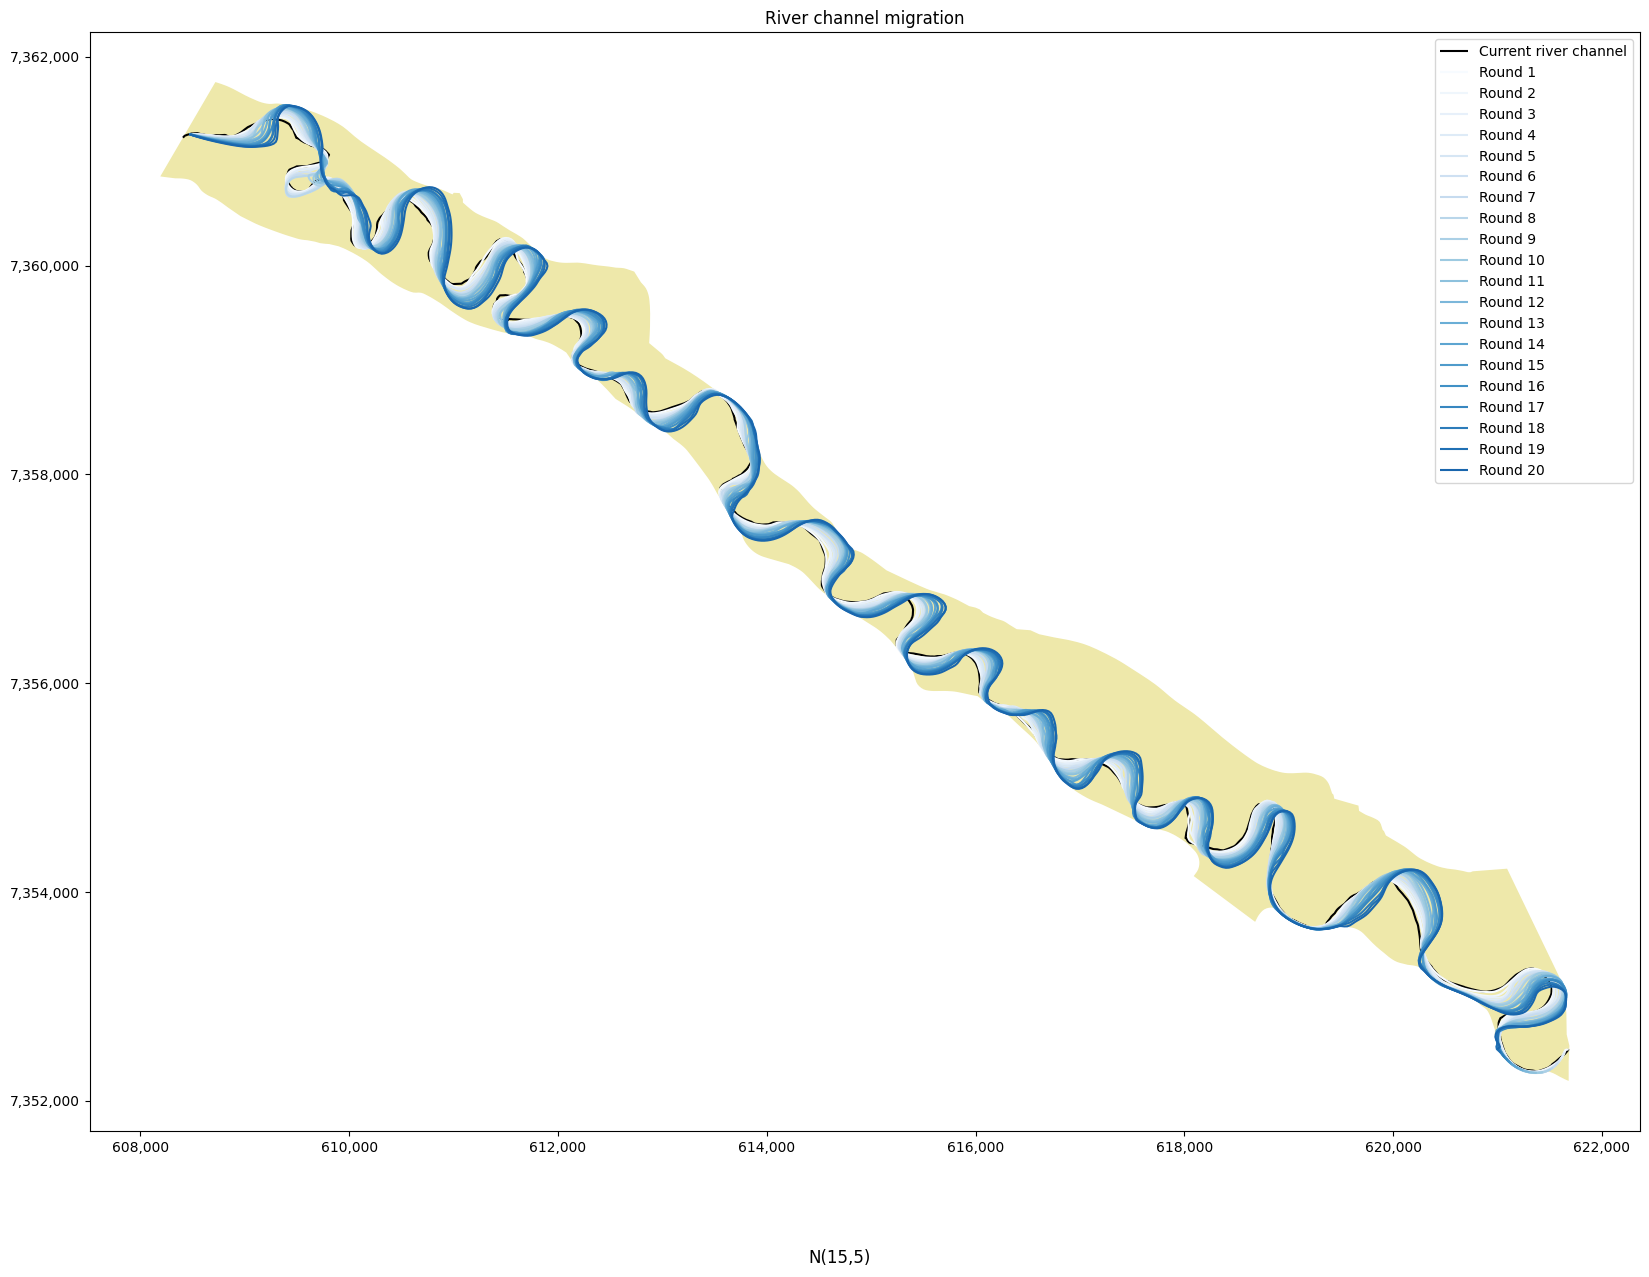

In [32]:
#ALGORITHM

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset, cut_off_distance, feasible_region):
    new_points = {}
    spline = {}
    spline_gdf = {}
    oxbow_points = []

    for s in range(N_s):

        # Initialize a GeoDataFrame to store the new points
        new_points[s] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'meander'])

        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], 4)

        # Define meander bends
        define_meander(channel_path, inflection_points)
        # Add into new_points
        new_points[s]['meander'] = channel_path['meander']

        # Define top points
        top = define_top_points(inflection_points, channel_path)
        
        # Radius of circles which are defined by three consecutive points
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        # Add into new_points
        new_points[s]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of the current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        #D_direction, L_direction = define_directions(inflection_points) # 90

        D_direction, L_direction = define_directions_top(inflection_points, top) # huippu


        # Sample horizontal and lateral offsets from Gaussian distribution

        '''

        By changing these: 

        1.Pure lateral reverse migration : OD = 0 and OL ~ N(mean,sd), 

        2.Pure reverse downstream migration : OD ~ N(mean, sd) and  OL = 0, 

        3.Mixed reverse migration : OD ~ N(mean, sd) and OL ~ N(mean,sd), 
        

        Migration with accepting/not accepting negative offsets,
        can be modified in function called "offsets"
        
        '''
    
        OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OD = np.zeros(N_hm)

        OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OL = np.zeros(N_hm)

        # Sample smoothing values sL and sD from a uniform distribution
        
        max_OD = max(np.abs(OD))
        max_OL = max(np.abs(OL))

        min_sD = 0
        max_sD = 2 * max_OD

        min_sL = 0
        max_sL = 2 * max_OL

        sD = np.random.uniform(min_sD, max_sD, N_hm)  # zero if OD is zero
        sL = np.random.uniform(min_sL, max_sL, N_hm) # zero if OL is zero
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one meander
            pm = (channel_path['meander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            #Move points

            for pn in range(len(filtered_pm['geometry'])):

                new_point = (
                    filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *   L_direction[hm][0])) ,
                    filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *   L_direction[hm][1]))
                    )
                if not np.isnan(new_point).all():
                    newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                    newpoint_list.append(newpoint)
                else:
                    newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                    newpoint_list.append(Point(newpoint)) 
             
                
        # Add new points to the GeoDataFrame
        new_points[s]['geometry'] = newpoint_list

        # Check if new obxbow lakes will appear
        channel_path_deleted_oxbows, oxbows = new_oxbow(channel_path, inflection_points, cut_off_distance)


        # If there is new oxbows
        if len(oxbows) > 0: 
            # Initialize geodataframe again for new points
            new_points[s]=gpd.GeoDataFrame(columns=['geometry'])

            # Add points without oxbow bends
            new_points[s]['geometry'] = [Point((point.x, point.y)) for point in channel_path_deleted_oxbows['geometry']]

            oxbow_points.append(oxbows)

        # Spline
        spline[s], spline_gdf[s] = create_spline((new_points[s]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # Update new path to next round
        channel_path = create_breakpoints(spline[s], 75)
        channel_path['geometry'] = channel_path['geometry'].iloc[::-1].values
        
    # Plot
    fig, ax = plt.subplots(figsize=(20, 15))

    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

    feasible_region.plot(ax=ax, color = 'palegoldenrod')
    
    # Original channel_path
    centerline.plot(ax=ax, color='black', label='Current river channel')
    # Splines of rounds
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        gpd.GeoDataFrame(geometry=[spline[i]]).plot(ax=ax, color=color, label=f'Round {i+1}')


    title_txt = "River channel migration"
    plt.title(title_txt)
    suptitle_text = f'N({mean_offset},{std_dev_offset})'
    plt.suptitle(suptitle_text, x=0.5, y=0.05, ha='center')
    plt.legend()
    plt.show()


'''

Input

N_s: Number of simulations.

channel_path: Current river channel.

mean_offset: Average D and L migration distance.
std_dev_offset: Standard deviation of D and L migration distances.

cut_off: Cut-off distance for oxbowlakes.
feasible_region: Feasible region for channel migration.

'''

N_s = 20

channel_path = points

mean_offset = 15
std_dev_offset = 5

cut_off = 150

feasible_region = feasible_region

reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset,  cut_off, feasible_region)
